In [85]:
import time
from os import walk
import os.path as ospa
import numpy as np
import re
import matplotlib.pyplot as plt
# import mpl_toolkits.mplot3d.axes3d as p3
# import matplotlib.animation as animation
import pandas as pd

# %matplotlib notebook 
# %matplotlib notebook 

plt.rcParams.update({'font.size': 14})

# dataPath = "./UserStudyData_Self20220519"
dataPath = "./ChristinaDemo"
# dataPath = "./BernardDemo"

In [86]:
'''
General function
'''

def aPlot(figName, is3D = False):
    ax = []
    
    fig1 = plt.figure(figsize = (12,4))
    fig1.suptitle(figName, fontsize=16)
    if(is3D):
        ax = fig1.add_subplot(111, projection='3d')
    else:
        ax = fig1.add_subplot(111)
        
    return ax

# The default decoding format is one float number
def decodeTrackData(dataFormat, dataStr, numFormat = "\d+\.\d+", numNum = 1):
    findResult = re.findall(dataFormat, aLine)
    
    findData = []
    
    if findResult:
        findNums = re.findall(numFormat, findResult[0])
        if(len(findNums) != numNum):
            print("Incorrectly find %d %s given %d in command" % (len(findNums), numFormat, numNum))
            return findData
        else:
            for num in findNums:
                try:
                    num = float(num)
                except:
                    pass               
                findData.append(num)

    else: # Padding None if no number is found
        findData = [None] * numNum
        
    return findData

def decodeTaskSummary(taskFormat, completeStatusFormat, completeTimeFormat, dataStr):
    findData = []
    
    taskSummaries = re.findall(taskFormat+completeStatusFormat+completeTimeFormat, dataStr)
    
    for taskSummary in taskSummaries:
        res = re.findall(taskFormat+"|"+completeStatusFormat+"|"+completeTimeFormat, taskSummary)
        try:
            res[2] = float(res[2])
        except:
            pass   
        findData.append(res)
    
    return findData
    

In [87]:
'''
Data format
'''

vrDataInfo = [] # dataStamp, trialNum, voltageLevel, startTime, score
vrDataTrack = {} # time (secs), indexX, indexY, indexZ, thumbX, thumbY, thumbZ, indexDist, thumbDist, object
vrDataSummary = {} # object, taskResult, competeTime (secs)

for root, directories, files in walk(dataPath):
    for fileName in files:
        print(fileName)
        if(re.search('\.txt', fileName)):
            condi = re.split('_|\.txt', fileName)
            dataStamp = condi[0]
            trialNum = int(re.findall("\d+", condi[-2])[0])

            file1 = open(ospa.join(root, fileName), 'r')
            fileLines = file1.readlines()
            
            dataTrack = [] # time (secs), indexX, indexY, indexZ, thumbX, thumbY, thumbZ, indexDist, thumbDist, object
            subjectId = None
            taskId = None
            voltageLevel = None # voltageLevel, 
            startTime = None # startTime (Universal Time)
            dataSummary = [] # object, taskResult, competeTime (secs)
            score = None # Final score               
            
            for aLine in fileLines:
                if(aLine[0] == 't'):  
                    aTrackFrame = []
                    
                    # time (secs)
                    aTrackFrame.extend(decodeTrackData("t\d+\.\d+", aLine))
                    
                    # (indexX, indexY, indexZ)
                    aTrackFrame.extend(decodeTrackData("le\(\d+\.\d+, \d+\.\d+, \d+\.\d+\)", aLine, "\d+\.\d+", 3))
            
                    # (thumbX, thumbY, thumbZ)
                    aTrackFrame.extend(decodeTrackData("re\(\d+\.\d+, \d+\.\d+, \d+\.\d+\)", aLine, "\d+\.\d+", 3))
                    
                    # (indexX, indexY, indexZ)
                    aTrackFrame.extend(decodeTrackData("in\(\d+\.\d+, \d+\.\d+, \d+\.\d+\)", aLine, "\d+\.\d+", 3))
            
                    # (thumbX, thumbY, thumbZ)
                    aTrackFrame.extend(decodeTrackData("th\(\d+\.\d+, \d+\.\d+, \d+\.\d+\)", aLine, "\d+\.\d+", 3))
                    
                    # indexDist
                    aTrackFrame.extend(decodeTrackData("indi\d+\.\d+", aLine))
                    
                    # thumbDist
                    aTrackFrame.extend(decodeTrackData("thdi\d+\.\d+", aLine))
                    
                    # object (Name)
                    aTrackFrame.extend(decodeTrackData("Grape\d+|Key\d+", aLine, "Grape\d+|Key\d+"))
             
                    dataTrack.append(aTrackFrame)
                
                elif(aLine[0] == 'v'):
                    voltageLevel = decodeTrackData("voltLevel\d+", aLine, "\d+")[0]
                    
                    startTime = decodeTrackData("starttimestamp\d+", aLine, "\d+")[0]
                    
                    subjectId = decodeTrackData("subjectid\d+", aLine, "\d+")[0]
                    
                    taskId = decodeTrackData("taskid\d+", aLine, "\d+")[0]
                    
                    completeInfo = re.findall("completeinfo.*", aLine)[0]
                    
                    dataSummary = []
                    dataSummary.extend(decodeTaskSummary("Grape\d+", "[a-zA-Z]+", "\d+\.\d+", completeInfo))
                    dataSummary.extend(decodeTaskSummary("A\d+E\d+", "[a-zA-Z]+", "\d+\.\d+", completeInfo))
                    
                    score = decodeTrackData("score\d+", completeInfo, "\d+")[0]
            
            vrDataTrack[dataStamp] = pd.DataFrame(dataTrack, columns = ['Time', 'LeftEyeX', 'LeftEyeY', 'LeftEyeZ', 
                                                                        'RightEyeX', 'RightEyeY', 'RightEyeZ', 
                                                                        'IndexX', 'IndexY', 'IndexZ', 
                                                                        'ThumbX', 'ThumbY', 'ThumbZ', 
                                                                        'IndexDist', 'ThumbDist', 'Object'])
            # Analyze grasp/push distance (May not work)
            ind = (vrDataTrack[dataStamp]['Object'].notnull())            
            tmp = vrDataTrack[dataStamp][ind]['IndexDist']
            indexDistMean = np.mean(tmp)
            indexDistSTD = np.std(tmp)
            tmp = vrDataTrack[dataStamp][ind]['ThumbDist']
            thumbDistMean = np.mean(tmp)
            thumbDistSTD = np.std(tmp)
            
            
            vrDataSummary[dataStamp] = pd.DataFrame(dataSummary, columns = ['Object', 'TaskResult', 'CompeteTime'])
            ind = (vrDataSummary[dataStamp]['TaskResult'].values == 'burst')
            burstNum = np.sum(ind)          
            
            # Final report
            vrDataInfo.append([dataStamp, trialNum, subjectId, taskId, voltageLevel, startTime, score, burstNum,
                              indexDistMean, indexDistSTD, thumbDistMean, thumbDistSTD])
            
vrDataInfo = pd.DataFrame(vrDataInfo, columns = ['Label', 'Trial', 'SubjectId', 'TaskId', 'VoltLevel', 
                                                 'StartTime', 'Score', 'BurstNum',
                                                 'InDiMean', 'InDiSTD', 'ThDiMean', 'ThDiSTD'])        
print(vrDataInfo)

Data11-40-01_s013_t000.txt
Data11-40-41_s013_t001.txt
Data11-41-18_s013_t002.txt
Data11-41-53_s013_t003.txt
Data11-42-29_s013_t004.txt
Data11-43-05_s013_t005.txt
Data11-45-42_s013_t000.txt
Data11-46-17_s013_t001.txt
Data11-46-59_s013_t002.txt
Data11-47-36_s013_t003.txt
Data11-48-17_s013_t004.txt
Data11-49-01_s013_t005.txt
           Label  Trial  SubjectId  TaskId  VoltLevel  StartTime  Score  \
0   Data11-40-01      0       13.0     0.0      100.0       78.0    1.0   
1   Data11-40-41      1       13.0     1.0        0.0      118.0    0.0   
2   Data11-41-18      2       13.0     2.0        0.0      155.0    0.0   
3   Data11-41-53      3       13.0     3.0      100.0      190.0    0.0   
4   Data11-42-29      4       13.0     4.0      100.0      226.0    0.0   
5   Data11-43-05      5       13.0     5.0        0.0      262.0    0.0   
6   Data11-45-42      0       13.0     0.0      100.0      419.0    0.0   
7   Data11-46-17      1       13.0     1.0        0.0      454.0    3.0   
8

In [88]:
# vrDataInfo = vrDataInfo[:6]
vrDataInfo = vrDataInfo[6:]
print(vrDataInfo)

           Label  Trial  SubjectId  TaskId  VoltLevel  StartTime  Score  \
6   Data11-45-42      0       13.0     0.0      100.0      419.0    0.0   
7   Data11-46-17      1       13.0     1.0        0.0      454.0    3.0   
8   Data11-46-59      2       13.0     2.0        0.0      496.0    3.0   
9   Data11-47-36      3       13.0     3.0      100.0      533.0    3.0   
10  Data11-48-17      4       13.0     4.0      100.0      574.0    1.0   
11  Data11-49-01      5       13.0     5.0        0.0      618.0    2.0   

    BurstNum  InDiMean   InDiSTD  ThDiMean   ThDiSTD  
6          0  0.396000  0.011896  0.422024  0.011693  
7          0  0.391840  0.011817  0.419621  0.012944  
8          0  0.392878  0.018816  0.410053  0.018995  
9          0  0.402833  0.019691  0.420075  0.017573  
10         0  0.514411  0.066029  0.518317  0.058519  
11         0  0.399933  0.014694  0.421340  0.014517  


Data11-46-17
Data11-46-59
Data11-49-01
Data11-45-42
Data11-47-36
Data11-48-17


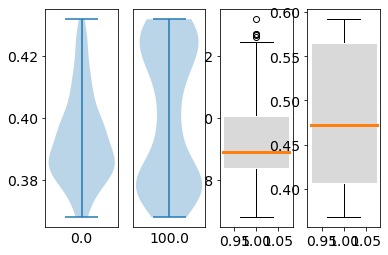

In [90]:
# Plot grasp/push distance results

fig1 = plt.figure()
# ax = fig1.add_subplot(111)

# A rough view (May not work)
# ax.errorbar(x=vrDataInfo.index, y=vrDataInfo['InDiMean'], yerr=vrDataInfo['InDiSTD'], marker='.', linestyle='')
# ax.set_xticks(vrDataInfo.index)
# ax.set_xlabel('VoltLevel')
# ax.set_xticklabels(vrDataInfo['VoltLevel'], rotation=80);

# More detailed view
voltLevels = [0.0, 100.0]

boxprops = dict(linestyle='-', linewidth=1, color='w', facecolor='0.85')
medianprops = dict(linestyle='-', linewidth=3, color='tab:orange')

# distData = []
for i in range(len(voltLevels)):
    vL = voltLevels[i]
    matchedLabels = vrDataInfo.loc[vrDataInfo['VoltLevel'] == vL, 'Label']
    
    currDistData = np.array([])
    for aLabel in matchedLabels: 
        print(aLabel)
        tmp = vrDataTrack[aLabel][vrDataTrack[aLabel]['Object'].notnull()]['IndexDist'].values
        currDistData = np.append(currDistData, tmp)
    
    ax = plt.subplot(1, 4, i+1)
    ax.violinplot(currDistData)
    plt.xticks([])
    if i > 0:
        plt.yticks([])
    plt.xlabel(vL)
    
    ax1 = plt.subplot(1, 4, i+3)
    ax1.boxplot(currDistData, widths = 0.15, manage_ticks = False, medianprops=medianprops, 
                 patch_artist=True, boxprops=boxprops, notch = False, showfliers = True)
#     ax1.set_ylim([0, 0.09])

In [ ]:

# for aLabel in vrDataInfo['Label']:
# aLabel = 'Data20-30-49'
# print(aLabel)
# trData = vrDataTrack[aLabel]
    
# ind = (trData['Object'].values != None)
# print(trData[ind]['IndexDist']) 
    
    
# for index, row in trData.iterrows():
#     print(row['Object'])
    

In [ ]:
'''
Select one trial of data and replay the tracked scene
'''

selectLabel = dataStamp # The most recent data

trData = vrDataTrack[selectLabel]
trData.head()

In [ ]:
'''
Plot Tracking data
'''
t = trData['Time'].values
t = t - t[0]

eyeCenter = np.array([0.5 * (trData['LeftEyeX'].values + trData['RightEyeX'].values), 
                      0.5 * (trData['LeftEyeY'].values + trData['RightEyeY'].values), 
                      0.5 * (trData['LeftEyeZ'].values + trData['RightEyeZ'].values)]).T

eyeLinkVect = np.array([trData['LeftEyeX'].values - trData['RightEyeX'].values, 
               trData['LeftEyeY'].values - trData['RightEyeY'].values, 
               trData['LeftEyeZ'].values - trData['RightEyeZ'].values]).T

index = np.array([trData['IndexX'].values, trData['IndexY'].values, trData['IndexZ'].values]).T
thumb = np.array([trData['ThumbX'].values, trData['ThumbY'].values, trData['ThumbZ'].values]).T

fig1 = plt.figure()
ax = fig1.add_subplot(111, projection='3d')
ax.set_xlabel('X (m)')
ax.set_ylabel('Z (m)')
ax.set_zlabel('Y (m)')

ax.set_xlim([1.2, 2.0])
ax.set_ylim([0.0, 2.0])
ax.set_zlim([1.0, 2.0])

axHandle = ax.plot([0, 0]+eyeCenter[0,0], [0, 0]+eyeCenter[0,2], [0, 1]+eyeCenter[0,1],'tab:green')[0]
axHandle2 = ax.plot(eyeCenter[0,0], eyeCenter[0,2], eyeCenter[0,1],'or')[0]

axHandle3 = ax.plot(index[0,0], index[0,2], index[0,1],'ob')[0]
axHandle4 = ax.plot(thumb[0,0], thumb[0,2], thumb[0,1],'oc')[0]

ax.view_init(elev = 45, azim=0.0)

for t_i, eC, eL, index_i, thumb_i in zip(t, eyeCenter, eyeLinkVect, index, thumb):
    plt.title("Time = %.3f sec" % t_i)
    
    normVect = np.cross([0,1,0], eL)  
    normVect = normVect / np.linalg.norm(normVect)
    
    axHandle.set_xdata([0, normVect[0]]+eC[0])
    axHandle.set_ydata([0, normVect[2]]+eC[2])
    axHandle.set_3d_properties([0, normVect[1]]+eC[1])
    
    axHandle2.set_xdata(eC[0])
    axHandle2.set_ydata(eC[2])
    axHandle2.set_3d_properties(eC[1])
    
    axHandle3.set_xdata(index_i[0])
    axHandle3.set_ydata(index_i[2])
    axHandle3.set_3d_properties(index_i[1])
    
    axHandle4.set_xdata(thumb_i[0])
    axHandle4.set_ydata(thumb_i[2])
    axHandle4.set_3d_properties(thumb_i[1])
    
    fig1.canvas.draw()